In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [42]:
# Here we create an Spark application. We cannot use pyspark without session
spark = SparkSession.builder.appName("ALS").getOrCreate()

# Reading the filtered dataset
ratings_df = spark.read.csv('../data/processed/df_no_cold_start.csv', header=True, inferSchema=True)

In [43]:
# Here we perform a little bit of post processing, where ids of customers and products are resetted such that they start and 1 and increase with step 1
product_indexer = StringIndexer(inputCol="product_id", outputCol="product_id_indexed")
indexed_df = product_indexer.fit(ratings_df).transform(ratings_df)
indexed_df = indexed_df.withColumn("product_id_indexed", col("product_id_indexed").cast("integer"))

indexed_df = indexed_df.withColumn('customer_id_str', col('customer_id').cast('string'))

indexer = StringIndexer(inputCol='customer_id_str', outputCol='customer_id_indexed')

indexed_df = indexer.fit(indexed_df).transform(indexed_df)
indexed_df = indexed_df.withColumn("customer_id_indexed", col("customer_id_indexed").cast("integer"))
indexed_df.head(5)

[Row(_c0=0, Unnamed: 0=57, customer_id=38443412, product_id='B00HQVTMK0', star_rating=2, product_id_indexed=8296, customer_id_str='38443412', customer_id_indexed=10174),
 Row(_c0=1, Unnamed: 0=63, customer_id=35789310, product_id='B00F877VES', star_rating=4, product_id_indexed=4780, customer_id_str='35789310', customer_id_indexed=1010),
 Row(_c0=2, Unnamed: 0=68, customer_id=38575075, product_id='B008EPW7TA', star_rating=5, product_id_indexed=528, customer_id_str='38575075', customer_id_indexed=80),
 Row(_c0=3, Unnamed: 0=74, customer_id=12166830, product_id='B008UGPBXM', star_rating=5, product_id_indexed=1649, customer_id_str='12166830', customer_id_indexed=3136),
 Row(_c0=4, Unnamed: 0=107, customer_id=19951707, product_id='B00CTKBTH2', star_rating=4, product_id_indexed=4713, customer_id_str='19951707', customer_id_indexed=4141)]

In [87]:
# splitting the dataset
(training, val, test) = indexed_df.randomSplit([0.7, 0.15, 0.15])

In [88]:
# Here we perform hyperparameter optimization.

# those 2 hyperparameters do not change by splitting, so they are constant and tuned by hand
rank = 30
maxIter = 15

# RMSE calculator
evaluator_1 = RegressionEvaluator(metricName="rmse", labelCol="star_rating", predictionCol="prediction")

regParams = [0.5, 0.6, 0.7, 0.8, 0.9, 1] # values for regParam in hyperparameter optimization
rmse_train_list = [] 
rmse_val_list = []
for regParam in regParams:
  # creating the model and training it
  als = ALS(userCol="customer_id_indexed",rank = rank, regParam = regParam, maxIter = maxIter, itemCol="product_id_indexed", ratingCol="star_rating", coldStartStrategy="drop")
  model = als.fit(training)

  # evaluation part
  predictions_train = model.transform(training)
  predictions_val = model.transform(val)

  rmse_train = evaluator_1.evaluate(predictions_train)
  rmse_val = evaluator_1.evaluate(predictions_val)
  rmse_train_list.append(rmse_train)
  rmse_val_list.append(rmse_val)

Text(0, 0.5, 'RMSE')

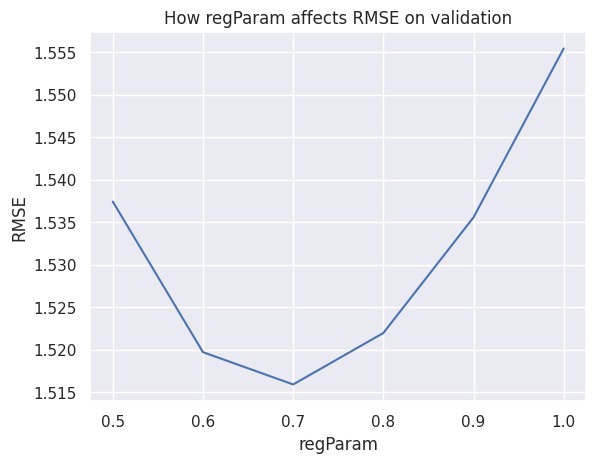

In [89]:
# Here is the plot that helps to choose regParam
plt.plot(regParams, rmse_val_list)
plt.title("How regParam affects RMSE on validation")
plt.xlabel("regParam")
plt.ylabel("RMSE")

In [90]:
# taking best value of regParam, we train best model
als = ALS(userCol="customer_id_indexed",rank = rank, regParam = 0.7, maxIter = maxIter, itemCol="product_id_indexed", ratingCol="star_rating", coldStartStrategy="drop")
model = als.fit(training)

In [91]:
# Check the model on test
predictions_train = model.transform(training)
predictions_test = model.transform(test)
print(f"RMSE on test is {evaluator_1.evaluate(predictions_test)}, on train is {evaluator_1.evaluate(predictions_train)}")

RMSE on test is 1.606054766847577, on train is 1.615965100129146
